In [214]:
from math import pi
import numpy as np
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA

In [215]:
numx       = 3
numq       = 3
num_layers = 2
numtheta   = numq*(num_layers+3)
num_out    = 1
num_in     = 2**numq

x          = ParameterVector('x', numx)
theta      = ParameterVector('θ', numtheta)

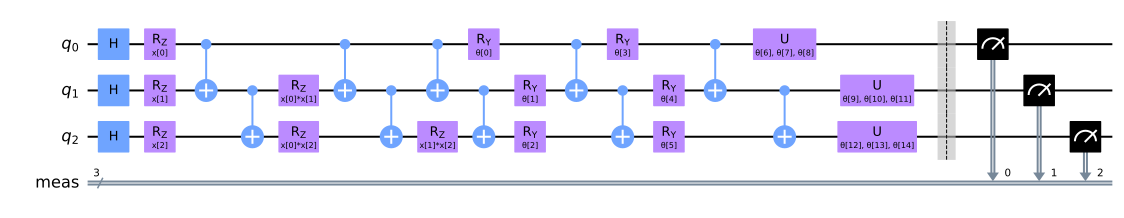

In [216]:
model = QuantumCircuit(numq)

for q in range(numq):
    model.h(q)

for i in range(numx):
    model.rz(x[i], i)

for q in range(numq-1):
    model.cx(q, q+1)

for l in range(numx-1):
    for i in range(l+1, numx):
        model.rz(x[l]*x[i], i)

    for q in range(numq-1):
        model.cx(q, q+1)

for l in range(num_layers):
    for q in range(numq):
        idx = numq*l+q
        model.ry(theta[idx], q)

    for q in range(numq-1):
        model.cx(q, q+1)

for q in range(numq):
        idx = numq*num_layers+3*q
        model.u(theta[idx], theta[idx+1], theta[idx+2], q)

model.measure_all()
model.draw()

In [217]:
def eval_model(device, shots, input, params):
    theta_    = params[:numtheta]
    weights   = params[numtheta:]
    weights   = np.reshape(weights, (num_out, num_in)) 
    
    instance  = model.bind_parameters({x: input, theta: theta_})

    results   = device.run(instance, shots=shots).result()
    counts    = results.get_counts()
    countsvec = np.zeros((num_in))
    
    normf     = sum(counts.values())
    for key, value in counts.items():
        idx            = int(key, 2)
        countsvec[idx] = float(value)/float(normf) 

    predict = weights @ countsvec

    return predict

In [218]:
seed = 0
rng  = np.random.default_rng(seed=seed)

samplex     = rng.uniform(low=-2*pi, high=2*pi,  size=numx)
sampletheta = rng.uniform(low=-2*pi, high=2*pi,  size=numtheta)
weights     = rng.uniform(low=-1000, high=1000,  size=num_out*num_in)

params      = np.concatenate((sampletheta, weights))

In [219]:
device  = AerSimulator()
shots   = 1000

predict = eval_model(device, shots, samplex, params)

In [220]:
print(predict)

[-162.21655904]


In [221]:
data   = [[0.1, 0.2, 15.], [0.5, 0.8, 100.]]
labels = [0.22, 16.]
M      = len(labels)

In [222]:
# MSE (normalized)
def cost(params):

    C = 0.
    for m in range(M):
        error = labels[m] - eval_model(device, shots, data[m], params)
        error = np.inner(error, error)/np.inner(labels[m], labels[m])
        C    += error

    C /= M

    return C

In [230]:
energy = []
def callback(nev, x, fval, h, accept):
    energy.append(fval)

spsa          = SPSA(maxiter=300, callback=callback)
initial_point = params
result        = spsa.minimize(cost, initial_point)

/tmp/ipykernel_26280/705941679.py:7: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  result        = spsa.optimize(len(params), cost, initial_point=initial_point, callback=callback)


TypeError: SPSA.optimize() got an unexpected keyword argument 'callback'

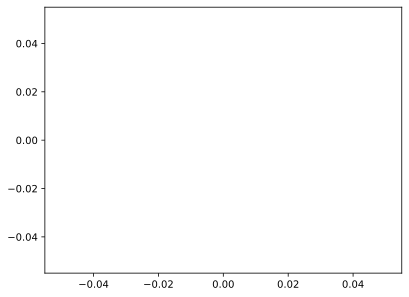

In [224]:
plt.plot(energy)

In [225]:
opt_params = result.x
eval_model(device, shots, data[1], opt_params)

array([-304.1760922])